# OFA³: Automatic Selection of the Best Non-dominated Sub-networks for Ensembles

- **Description**: 

- **arXiv link**: TBA

- **Author**: TBA (hidden due to blind review)
- **email**: TBA (hidden due to blind review)

# Imports

In [1]:
# general
import os
import time
import math
import random
import pickle
from tqdm.notebook import tqdm

# AI/ML/NN
import numpy as np
import pandas as pd
from scipy.stats import mstats
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms

# Matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
import matplotlib.lines as mlines

# OFA²
from ofa2.model_zoo import ofa_net 
from ofa2.imagenet_classification.elastic_nn.utils import set_running_statistics
from ofa2.utils import AverageMeter
from ofa2.tutorial.latency_table import LatencyEstimator, LatencyTable
from ofa2.tutorial import EvolutionFinder
from ofa2.tutorial.accuracy_predictor import AccuracyPredictor

In [2]:
# set random seeds for reproducibility
random_seed = 1
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [3]:
# set device to use GPU or CPU
cuda_available = torch.cuda.is_available()
if cuda_available:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed(random_seed)
    print("Using GPU.")
else:
    print("Using CPU.")
cuda0 = torch.device('cuda:0')

Using GPU.


In [4]:
# colors used in matplotlib curves
blue   = '#1f77b4'
orange = '#ff7f0e'
green  = '#2ca02c'
red    = '#d62728'
purple = '#9467bd'
brown  = '#8c564b'
pink   = '#e377c2'
gray   = '#7f7f7f'
olive  = '#bcbd22'
cyan   = '#17becf'
black  = '#000000'

# Get OFA network

In [5]:
ofa_network = ofa_net("ofa_mbv3_d234_e346_k357_w1.2", pretrained=True)
# ofa_network2 = torch.load(model_dir='~/model/ofa_mbv3_d234_e346_k357_w1.2')

# Dataset & DataLoader

In [6]:
# ImageNet Full
imagenet_data_path = "~/dataset/imagenet/"
#----------------------------
# ImageNet subset
#imagenet_data_path = "~/dataset/imagenet_1k"

In [7]:
# os.makedirs(imagenet_data_path, exist_ok=True)
# download_url('https://hanlab.mit.edu/files/OnceForAll/ofa_cvpr_tutorial/imagenet_1k.zip', model_dir='data')
#! cd data && unzip imagenet_1k 1>/dev/null && cd ..
#! cp -r data/imagenet_1k/* $imagenet_data_path
#! rm -rf data

In [8]:
# The following function build the data transforms for test
def build_val_transform(size):
    return transforms.Compose(
        [
            transforms.Resize(int(math.ceil(size / 0.875))),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

In [9]:
#imagenet_train = datasets.ImageFolder(root=os.path.join(imagenet_data_path, "train"), transform=build_val_transform(224))
#imagenet_train_subset = datasets.ImageFolder(root=os.path.join(imagenet_data_path, "train_subset_50k"), transform=build_val_transform(224))
imagenet_val = datasets.ImageFolder(root=os.path.join(imagenet_data_path, "val"), transform=build_val_transform(224))

In [10]:
## this dataloader is for the training set --> used to guide the search
#data_loader_train = torch.utils.data.DataLoader(
#    imagenet_train,
#    batch_size=1024,  # evaluation batch size
#    shuffle=False,    # evaluation only
#    num_workers=8,    # number of workers for the data loader
#    pin_memory=True,
#    drop_last=False,
#)
#print("The ImageNet dataloader for the training set is ready.")

In [11]:
## this dataloader is for the 50k subset of the training set --> used to generate probability table
#data_loader_train_subset = torch.utils.data.DataLoader(
#    datasets.ImageFolder(root=os.path.join(imagenet_data_path, "train_subset_50k"), transform=build_val_transform(224)),
#    batch_size=1_024, # evaluation batch size
#    shuffle=False,    # evaluation only
#    num_workers=8,    # number of workers for the data loader
#    pin_memory=True,
#    drop_last=False,
#)
#print("The ImageNet dataloader for the training set is ready.")

In [12]:
# this dataloader is for the validation set --> used to measure performance
data_loader_val = torch.utils.data.DataLoader(
    imagenet_val,
    batch_size=1_024, # test batch size
    shuffle=False,    # evaluation only
    num_workers=8,    # number of workers for the data loader
    pin_memory=True,
    drop_last=False,
)
print("The ImageNet dataloader for the validation set is ready.")

The ImageNet dataloader for the validation set is ready.


# Hyperparameters

In [13]:
""" Hyperparameters
- P: size of the population in each generation (number of individuals)
- N: number of generations to run the algorithm
"""
P = 100
N = 1_000

# Load the probability & class outputs of the OFA² models

In [14]:
# load last population of OFA² search
with open('ofa2_nsga2.pickle', 'rb') as f:
    ofa2_nsga2 = pickle.load(f)

In [15]:
n_outputs = 5                                   # number of outputs considered to build the cumulative table
n_models = len(ofa2_nsga2)                      # OFA² last population size: 100
ds_size = len(imagenet_val)            # ImageNet training set size: 50,000
n_classes = len(imagenet_val.classes)  # ImageNet classes: 1,000 
#----------------------------
#ds_size = len(imagenet_train_subset)            # ImageNet training set size: 1,281,167
#n_classes = len(imagenet_train_subset.classes)  # ImageNet classes: 1,000 

In [16]:
# create class and probabilities tables
top5_class = np.empty((n_models, ds_size, n_outputs), dtype=np.int16)   # shape = (100 x 1281167 x 5)
top5_prob = np.empty((n_models, ds_size, n_outputs), dtype=np.float32)  # shape = (100 x 1281167 x 5)
#-------------------------------------------------
# fill table with data from csv files of the 100 models found by OFA² search
for i in tqdm(range(n_models)):
    top5_class[i] = pd.read_csv('evaluation/ofa2/model_' + str(i).zfill(2) + '_class.csv', usecols=[0,1,2,3,4], header=None).values
    top5_prob[i] = pd.read_csv('evaluation/ofa2/model_' + str(i).zfill(2) + '_prob.csv', usecols=[0,1,2,3,4], header=None).values
#-------------------------------------------------
# ground truth labels
labels = pd.read_csv('evaluation/ofa2/model_' + str(0).zfill(2) + '_class.csv', usecols=[5], header=None).values.squeeze()

  0%|          | 0/100 [00:00<?, ?it/s]

# Fill the cumulative probability lookup table

In [17]:
# create cumulative lookup table of probabilities: shape = (100 x 1281167 x 1000)
cumulative_lut = np.empty((n_models, ds_size, n_classes), dtype=np.float32)

In [18]:
# start measuring time
start_time = time.time()
#-------------------------------------------------
# loop over models (0~99)
for model_id in tqdm(range(n_models), position=1):
    # loop over each image output class (0~1281166): get lines of top5_class table
    #for i, output_classes in enumerate(tqdm(top5_class[model_id], position=0, leave=False)):
    for i, output_classes in enumerate(top5_class[model_id]):
        # loop over each top-5 outputs (0~4): get rows of top5_class table & respective rows of top5_prob
        for j, topk in enumerate(output_classes):
            cumulative_lut[model_id, i, topk] += top5_prob[model_id, i, j]
#-------------------------------------------------
# stop measuring time
end_time = time.time()
#----------------------------
elapsed = end_time - start_time
print('The creation of the cumulative probability lookup tables took', time.strftime("%Hh%Mm%Ss", time.gmtime(elapsed)), 'to finish.')

  0%|          | 0/100 [00:00<?, ?it/s]

The creation of the cumulative probability lookup tables took 00h00m25s to finish.


In [19]:
# move the cumulative probability table to the GPU as a torch tensor (optional)
cumulative_lut = torch.tensor(cumulative_lut, device=cuda0)

# Evaluation functions

In [20]:
def individual_to_arch(population, n_blocks):
    archs = []
    for individual in population:
        archs.append(
            {
                "ks": individual[0:n_blocks],
                "e": individual[n_blocks : 2 * n_blocks],
                "d": individual[2 * n_blocks : -1],
                "r": individual[-1:],
            }
        )
    return archs

In [21]:
def individual_to_ofa(model):
    # insert wid
    model['wid'] = None
    # cast back from NumPy to list
    model['ks'] = model['ks'].tolist()
    model['e'] = model['e'].tolist()
    model['d'] = model['d'].tolist()
    model['r'] = model['r'].tolist()
    return model

In [22]:
def ensemble_evaluate_ofa_subnet(
    filename, ofa_net, path, net_config, data_loader, batch_size, device="cuda:0"
):
    assert "ks" in net_config and "d" in net_config and "e" in net_config
    assert (
        len(net_config["ks"]) == 20
        and len(net_config["e"]) == 20
        and len(net_config["d"]) == 5
    )
    ofa_net.set_active_subnet(ks=net_config["ks"], d=net_config["d"], e=net_config["e"])
    subnet = ofa_net.get_active_subnet().to(device)
    calib_bn(subnet, path, net_config["r"][0], batch_size)
    top1 = validate(filename, subnet, path, net_config["r"][0], data_loader, batch_size, device)
    return top1

In [23]:
def calib_bn(net, path, image_size, batch_size, num_images=2000):
    # print('Creating dataloader for resetting BN running statistics...')
    dataset = datasets.ImageFolder(
        os.path.join(path, "train"),
        transforms.Compose(
            [
                transforms.RandomResizedCrop(image_size),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=32.0 / 255.0, saturation=0.5),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        ),
    )
    chosen_indexes = np.random.choice(list(range(len(dataset))), num_images)
    sub_sampler = torch.utils.data.sampler.SubsetRandomSampler(chosen_indexes)
    data_loader = torch.utils.data.DataLoader(
        dataset,
        sampler=sub_sampler,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )
    # print('Resetting BN running statistics (this may take 10-20 seconds)...')
    set_running_statistics(net, data_loader)

In [24]:
# from: once-for-all/ofa/utils/common_tools.py
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    softmax = torch.nn.functional.softmax(output, dim=1)
    # prob, pred = softmax.topk(maxk, 1, True, True)
    prob, _ = softmax.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res, pred.t(), prob

In [25]:
def validate(filename, net, path, image_size, data_loader, batch_size=100, device="cuda:0"):
    if "cuda" in device:
        net = torch.nn.DataParallel(net).to(device)
    else:
        net = net.to(device)

    data_loader.dataset.transform = transforms.Compose(
        [
            transforms.Resize(int(math.ceil(image_size / 0.875))),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    cudnn.benchmark = True
    criterion = nn.CrossEntropyLoss().to(device)

    net.eval()
    net = net.to(device)
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    with torch.no_grad():
        with tqdm(total=len(data_loader), desc="Validate", leave=False) as t:
            for i, (images, labels) in enumerate(data_loader):
                images, labels = images.to(device), labels.to(device)
                # compute output
                output = net(images)
                loss = criterion(output, labels)
                #-----------------------------------------------------
                # measure accuracy and record loss
                res, pred, prob = accuracy(output, labels, topk=(1, 5))
                acc1 = res[0]
                acc5 = res[1]
                # save to CSV
                if filename is not None:
                    # print(f'{acc1=}, {acc5=}, {pred}, {labels=}')
                    labels_t = labels.t().unsqueeze(dim=1)
                    topk_classification = torch.cat((pred, labels_t), dim=1)
                    # cast to DataFrame
                    topk_df = pd.DataFrame(topk_classification.cpu())
                    topk_df.to_csv(filename + '_class.csv', mode='a', header=False, index=False)
                    # probability
                    topk_prob = pd.DataFrame(prob.cpu())
                    topk_prob.to_csv(filename + '_prob.csv', encoding='utf-8', mode='a', header=False, index=False)
                #-----------------------------------------------------
                                
                losses.update(loss.item(), images.size(0))
                top1.update(acc1[0].item(), images.size(0))
                top5.update(acc5[0].item(), images.size(0))
                t.set_postfix(
                    {
                        "loss": losses.avg,
                        "top1": top1.avg,
                        "top5": top5.avg,
                        "img_size": images.size(2),
                    }
                )
                t.update(1)

    print(
        "Results: loss=%.5f,\t top1=%.1f,\t top5=%.1f"
        % (losses.avg, top1.avg, top5.avg)
    )
    return top1.avg

In [26]:
def calc_acc_from_top1_table(top1_table, labels):
    return np.count_nonzero((top1_table == labels), axis=1) / len(labels) * 100        

# OFA

## Prediction

In [27]:
class OfaLatencyTable(LatencyTable):
    def __init__(self, device="note10", resolutions=(160, 176, 192, 208, 224)):
        self.latency_tables = {}

        for image_size in resolutions:
            self.latency_tables[image_size] = LatencyEstimator(
                url="https://hanlab.mit.edu/files/OnceForAll/tutorial/latency_table@%s/%d_lookup_table.yaml"
                % (device, image_size)
            )
            print("Built latency table for image size: %d." % image_size)

    def predict_efficiency(self, spec: dict):
        return self.latency_tables[spec["r"][0]].predict_network_latency_given_spec(
            spec
        )

In [28]:
# latency predictor
target_hardware = 'note10'
latency_table = OfaLatencyTable(device=target_hardware)

Downloading: "https://hanlab.mit.edu/files/OnceForAll/tutorial/latency_table@note10/160_lookup_table.yaml" to /home/jovyan/.hancai/latency_tools/160_lookup_table.yaml


Built latency table for image size: 160.


Downloading: "https://hanlab.mit.edu/files/OnceForAll/tutorial/latency_table@note10/176_lookup_table.yaml" to /home/jovyan/.hancai/latency_tools/176_lookup_table.yaml


Built latency table for image size: 176.


Downloading: "https://hanlab.mit.edu/files/OnceForAll/tutorial/latency_table@note10/192_lookup_table.yaml" to /home/jovyan/.hancai/latency_tools/192_lookup_table.yaml


Built latency table for image size: 192.


Downloading: "https://hanlab.mit.edu/files/OnceForAll/tutorial/latency_table@note10/208_lookup_table.yaml" to /home/jovyan/.hancai/latency_tools/208_lookup_table.yaml


Built latency table for image size: 208.


Downloading: "https://hanlab.mit.edu/files/OnceForAll/tutorial/latency_table@note10/224_lookup_table.yaml" to /home/jovyan/.hancai/latency_tools/224_lookup_table.yaml


Built latency table for image size: 224.


In [29]:
# accuracy predictor
accuracy_predictor = AccuracyPredictor(pretrained=True, device="cuda:0" if cuda_available else "cpu")

In [30]:
""" Hyper-parameters for the evolutionary search process
    You can modify these hyper-parameters to see how they influence the final ImageNet accuracy of the search sub-net.
"""
latency_constraint = 25  # ms, suggested range [15, 33] ms
P = 100  # The size of population in each generation
N = 500  # How many generations of population to be searched
r = 0.25  # The ratio of networks that are used as parents for next generation
params = {
    "constraint_type": target_hardware,  # Let's do FLOPs-constrained search
    "efficiency_constraint": latency_constraint,
    "mutate_prob": 0.1,  # The probability of mutation in evolutionary search
    "mutation_ratio": 0.5,  # The ratio of networks that are generated through mutation in generation n >= 2.
    "efficiency_predictor": latency_table,  # To use a predefined efficiency predictor.
    # "efficiency_predictor": flops_lookup_table,  # To use a predefined efficiency predictor.
    "accuracy_predictor": accuracy_predictor,  # To use a predefined accuracy_predictor predictor.
    "population_size": P,
    "max_time_budget": N,
    "parent_ratio": r,
}

In [31]:
# build the evolution finder
finder = EvolutionFinder(**params)

In [32]:
# latencies: 10, 15, 20, 25, 30, 35, 40, 45 [ms]
result_list = []
latency_list = range(15, 60, 5)

In [33]:
# run the OFA search for each latency in the list
for latency in latency_list:
    params['efficiency_constraint'] = latency
    finder = EvolutionFinder(**params)
    best_valids, best_info = finder.run_evolution_search()
    _, net_config, latency = best_info
    result_list.append(best_info)

Searching with note10 constraint (55): 100%|██████████| 500/500 [00:13<00:00, 37.21it/s]


In [34]:
ofa_accuracy_pred = []
ofa_models = []
ofa_latency = []
#----------------------------
for result in result_list:
    #ofa_accuracy_pred.append(100 * result[0])
    ofa_accuracy_pred.append(result[0])
    ofa_models.append(result[1])
    ofa_latency.append(result[2])

## Evaluation

In [35]:
# loop for each candidate to form the ensemble
for idx, model in enumerate(tqdm(ofa_models[:]), 0):
    filename = 'model_' + str(idx).zfill(2)
    path = os.path.join('evaluation', 'ofa', filename)
    # get classification label 
    top1 = ensemble_evaluate_ofa_subnet(
        path,
        ofa_network,
        imagenet_data_path,
        model,
        data_loader_val,
        batch_size=1_024,
        device="cuda:0" if cuda_available else "cpu",
    )
    del top1
    torch.cuda.empty_cache()

  0%|          | 0/9 [00:00<?, ?it/s]

Validate:   0%|          | 0/49 [00:00<?, ?it/s]

Results: loss=1.13747,	 top1=73.6,	 top5=91.4


Validate:   0%|          | 0/49 [00:00<?, ?it/s]

Results: loss=1.02974,	 top1=75.9,	 top5=92.7


Validate:   0%|          | 0/49 [00:00<?, ?it/s]

Results: loss=0.98003,	 top1=77.0,	 top5=93.3


Validate:   0%|          | 0/49 [00:00<?, ?it/s]

Results: loss=0.95450,	 top1=77.6,	 top5=93.7


Validate:   0%|          | 0/49 [00:00<?, ?it/s]

Results: loss=0.93742,	 top1=78.1,	 top5=93.9


Validate:   0%|          | 0/49 [00:00<?, ?it/s]

Results: loss=0.92829,	 top1=78.4,	 top5=94.2


Validate:   0%|          | 0/49 [00:00<?, ?it/s]

Results: loss=0.90793,	 top1=78.8,	 top5=94.4


Validate:   0%|          | 0/49 [00:00<?, ?it/s]

Results: loss=0.89304,	 top1=79.1,	 top5=94.5


Validate:   0%|          | 0/49 [00:00<?, ?it/s]

Results: loss=0.89903,	 top1=78.9,	 top5=94.5


In [36]:
# get top-1 outputs
ofa_top1 = torch.tensor([pd.read_csv('evaluation/ofa/model_' + str(i).zfill(2) + '_class.csv', usecols=[0], header=None).values for i in range(len(latency_list))]).squeeze()
#-------------------------------------------------
# ground truth labels
ofa_labels = torch.tensor(pd.read_csv('evaluation/ofa/model_' + str(0).zfill(2) + '_class.csv', usecols=[5], header=None).values).squeeze()
#-------------------------------------------------
# calculate evaluated accuracy
ofa_accuracy_eval = calc_acc_from_top1_table(ofa_top1, ofa_labels)

/tmp/ipykernel_342008/2969652685.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  ofa_top1 = torch.tensor([pd.read_csv('evaluation/ofa/model_' + str(i).zfill(2) + '_class.csv', usecols=[0], header=None).values for i in range(len(latency_list))]).squeeze()


## Plot

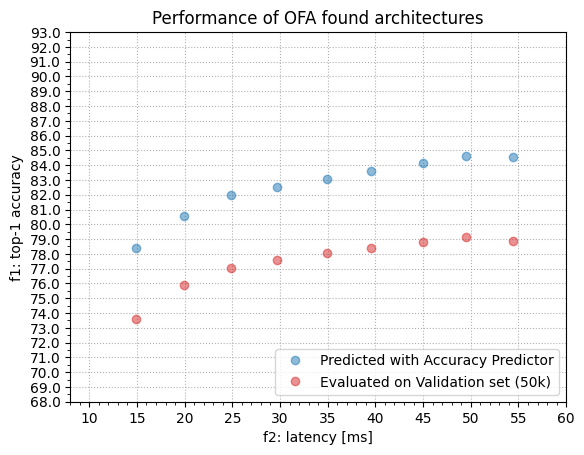

In [37]:
# Performance of OFA found architectures
x_min, x_max, y_min, y_max = 8, 60, 68, 93
ax_limits = [x_min, x_max, y_min, y_max]
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
ax.plot(ofa_latency, ofa_accuracy_pred, 'o', label='Predicted with Accuracy Predictor', color=blue,    alpha=0.5)
ax.plot(ofa_latency, ofa_accuracy_eval, 'o', label='Evaluated on Validation set (50k)', color=red,  alpha=0.5)
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('f2: latency [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('Performance of OFA found architectures')
ax.legend(loc='lower right')
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
#-------------------------------------------------
filename = os.path.join('figures', 'ofa_performance.png')
plt.savefig(filename)
fig.set_dpi(100)
# plt.close(fig)

# OFA²

## Prediction

In [38]:
# get latency of the models
ofa2_nsga2_latency = ofa2_nsga2.get('F')[:,0]
#----------------------------
# get accuracy of the models
ofa2_nsga2_accuracy_pred = 100 - ofa2_nsga2.get('F')[:,1]

## Evaluation

In [39]:
# prepare indivuals for evaluation
ofa2_arch = individual_to_arch(ofa2_nsga2.get('X'), 20)
ofa2_models = [individual_to_ofa(arch) for arch in ofa2_arch]

- These architectures should have been already evaluated in the Jupyter notebook "ofa2_5-generate-prob-validation-50k.ipynb".
- The next cell check if the directory and the evaluation file for the first model exists. If so, the evaluation is skipped.

In [40]:
if not os.path.exists('evaluation/ofa2/model_00_class.csv'):
    # loop for each candidate to form the ensemble
    for idx, model in enumerate(tqdm(ofa2_models[:]), 0):
        filename = 'model_' + str(idx).zfill(2)
        path = os.path.join('evaluation', 'ofa', filename)
        # get classification label 
        top1 = ensemble_evaluate_ofa_subnet(
            path,
            ofa_network,
            imagenet_data_path,
            model,
            data_loader_val,
            batch_size=1_024,
            device="cuda:0" if cuda_available else "cpu",
        )

In [41]:
# get top-1 outputs
ofa2_top1 = torch.tensor([pd.read_csv('evaluation/ofa2/model_' + str(i).zfill(2) + '_class.csv', usecols=[0], header=None).values for i in range(len(ofa2_nsga2))]).squeeze()
#-------------------------------------------------
# ground truth labels
ofa2_labels = torch.tensor(pd.read_csv('evaluation/ofa2/model_' + str(0).zfill(2) + '_class.csv', usecols=[5], header=None).values).squeeze()
#-------------------------------------------------
# calculate evaluated accuracy
ofa2_nsga2_accuracy_eval = calc_acc_from_top1_table(ofa2_top1, ofa2_labels)

## Plot

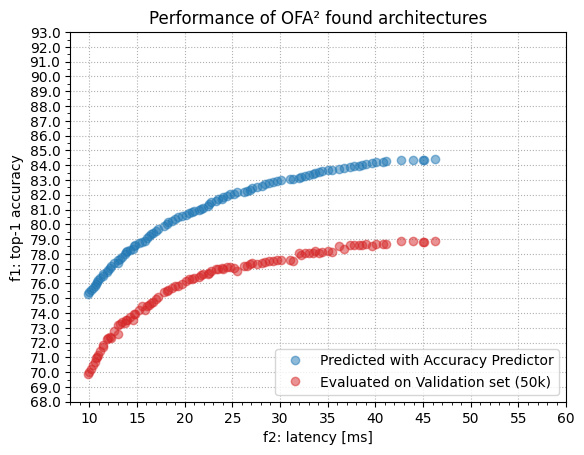

In [42]:
# Performance of OFA² found architectures
x_min, x_max, y_min, y_max = 8, 60, 68, 93
ax_limits = [x_min, x_max, y_min, y_max]
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
ax.plot(ofa2_nsga2_latency, ofa2_nsga2_accuracy_pred, 'o', label='Predicted with Accuracy Predictor', color=blue,    alpha=0.5)
ax.plot(ofa2_nsga2_latency, ofa2_nsga2_accuracy_eval, 'o', label='Evaluated on Validation set (50k)', color=red,  alpha=0.5)
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('f2: latency [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('Performance of OFA² found architectures')
ax.legend(loc='lower right')
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
#-------------------------------------------------
filename = os.path.join('figures', 'ofa2_performance.png')
plt.savefig(filename)
fig.set_dpi(100)
# plt.close(fig)

# OFA³

In [43]:
def calc_ensemble_accuracy(x, cumulative_table, labels, device):
    ind = torch.tensor(x, device=device, dtype=torch.float32)
    prob_table = torch.permute(cumulative_table, (1, 2, 0))
    out = torch.matmul(prob_table, ind)
    acc = torch.count_nonzero(torch.argmax(out, dim=1) == torch.tensor(labels, device=device), dim=0) / 50_000 * 100
    return acc.item()

In [44]:
def calc_ensemble_lat_sum(x, latency_table):
    return np.inner(x, latency_table)

In [45]:
def calc_ensemble_lat_max(x, latency_table):
    return np.max(np.multiply(x, latency_table), axis=1)

## Summed Latency

In [46]:
P = 100
N_sum = 200
history_sum = []

### Search

In [47]:
for generation in range(1, N_sum+1):
    filename = 'gen_' + str(generation).zfill(4) + '.pickle'
    with open(os.path.join('ofa3_ensemble', 'NSGA-II', 'soft-latsum-generation', 'seed_1', filename), 'br') as f:
        _, X, F, G = pickle.load(f)
    history_sum.append((X, F, G))

In [48]:
X_sum = []
lat_sum = []
acc_sum = []
size_sum = []
for hist in history_sum:
    X_sum.append(hist[0])
    lat_sum.append(hist[1][:,0])
    acc_sum.append(hist[1][:,1])
    size_sum.append(2 - hist[2])
#----------------------------
# fix first generation
X_sum[0] = np.repeat(X_sum[0], P, axis=0)
lat_sum[0] = np.repeat(lat_sum[0], P, axis=0)
acc_sum[0] = np.repeat(acc_sum[0], P, axis=0)
size_sum[0] = np.repeat(size_sum[0], P, axis=0)

### Evaluation

In [49]:
ofa3_sum_latency = calc_ensemble_lat_sum(X_sum[-1], ofa2_nsga2_latency)
ofa3_sum_accuracy_eval = [calc_ensemble_accuracy(X_sum[-1][i], cumulative_lut, labels, device=cuda0) for i in tqdm(range(len(X_sum[-1])))]

  0%|          | 0/100 [00:00<?, ?it/s]

### Plot

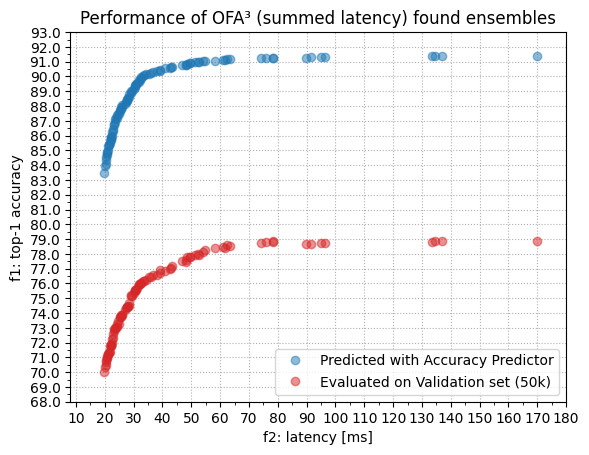

In [50]:
# Performance of OFA³ (summed latency) found architectures
x_min, x_max, y_min, y_max = 8, 180, 68, 93
ax_limits = [x_min, x_max, y_min, y_max]
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
ax.plot(lat_sum[-1], 100 - acc_sum[-1], 'o', label='Predicted with Accuracy Predictor', color=blue,    alpha=0.5)
ax.plot(ofa3_sum_latency, ofa3_sum_accuracy_eval, 'o', label='Evaluated on Validation set (50k)', color=red,  alpha=0.5)
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('f2: latency [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('Performance of OFA³ (summed latency) found ensembles')
ax.legend(loc='lower right')
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
#-------------------------------------------------
filename = os.path.join('figures', 'ofa3_summed_latency_performance.png')
plt.savefig(filename)
fig.set_dpi(100)
# plt.close(fig)

## Maximum Latency

In [51]:
P = 100
N_max = 2_000
history_max = []

### Search

In [52]:
for generation in range(1, N_max+1):
    filename = 'gen_' + str(generation).zfill(4) + '.pickle'
    with open(os.path.join('ofa3_ensemble', 'NSGA-II', 'soft-latmax-generation', 'seed_1', filename), 'br') as f:
        _, X, F, G = pickle.load(f)
    history_max.append((X, F, G))

In [53]:
X_max = []
lat_max = []
acc_max = []
size_max = []
for hist in history_max:
    X_max.append(hist[0])
    lat_max.append(hist[1][:,0])
    acc_max.append(hist[1][:,1])
    size_max.append(2 - hist[2])
#----------------------------
# fix first generation
X_max[0] = np.repeat(X_max[0], P, axis=0)
lat_max[0] = np.repeat(lat_max[0], P, axis=0)
acc_max[0] = np.repeat(acc_max[0], P, axis=0)
size_max[0] = np.repeat(size_max[0], P, axis=0)

### Evaluation

In [54]:
ofa3_max_latency = calc_ensemble_lat_max(X_max[-1], ofa2_nsga2_latency)
ofa3_max_accuracy_eval = [calc_ensemble_accuracy(X_max[-1][i], cumulative_lut, labels, device=cuda0) for i in tqdm(range(len(X_max[-1])))]

  0%|          | 0/100 [00:00<?, ?it/s]

### Plot

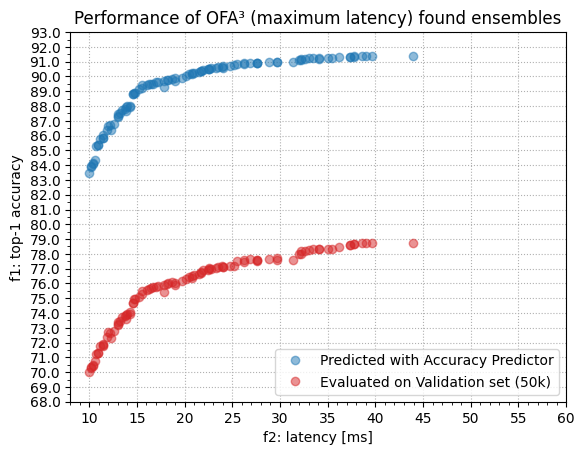

In [55]:
# Performance of OFA³ (maximum latency) found architectures
x_min, x_max, y_min, y_max = 8, 60, 68, 93
ax_limits = [x_min, x_max, y_min, y_max]
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
ax.plot(lat_max[-1], 100 - acc_max[-1], 'o', label='Predicted with Accuracy Predictor', color=blue,    alpha=0.5)
ax.plot(ofa3_max_latency, ofa3_max_accuracy_eval, 'o', label='Evaluated on Validation set (50k)', color=red,  alpha=0.5)
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('f2: latency [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('Performance of OFA³ (maximum latency) found ensembles')
ax.legend(loc='lower right')
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
#-------------------------------------------------
filename = os.path.join('figures', 'ofa3_maximum_latency_performance.png')
plt.savefig(filename)
fig.set_dpi(100)
# plt.close(fig)

# OFA/OFA²/OFA³ Comparison

## Predicted

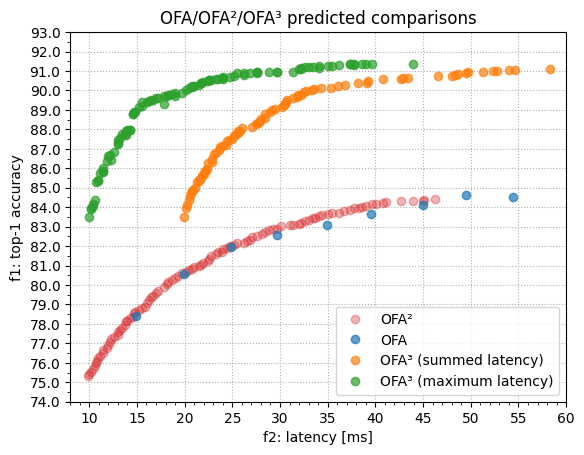

In [56]:
# OFA/OFA²/OFA³ predicted comparison
x_min, x_max, y_min, y_max = 8, 60, 74, 93
ax_limits = [x_min, x_max, y_min, y_max]
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
ax.plot(ofa2_nsga2_latency, ofa2_nsga2_accuracy_pred, 'o', label='OFA²',                   color=red,    alpha=0.35)
ax.plot(ofa_latency, ofa_accuracy_pred,               'o', label='OFA',                    color=blue,   alpha=0.70)
ax.plot(lat_sum[-1], 100 - acc_sum[-1],               'o', label='OFA³ (summed latency)',  color=orange, alpha=0.70)
ax.plot(lat_max[-1], 100 - acc_max[-1],               'o', label='OFA³ (maximum latency)', color=green,  alpha=0.70)
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('f2: latency [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('OFA/OFA²/OFA³ predicted comparisons')
ax.legend(loc='lower right')
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
#-------------------------------------------------
filename = os.path.join('figures', 'ofas_comparison_predicted.png')
plt.savefig(filename)
fig.set_dpi(100)
# plt.close(fig)

## Evaluated

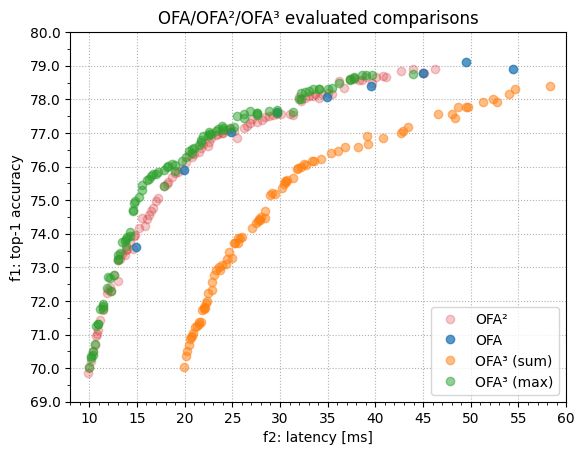

In [57]:
# OFA/OFA²/OFA³ evaluated comparison
x_min, x_max, y_min, y_max = 8, 60, 69, 80
ax_limits = [x_min, x_max, y_min, y_max]
#-------------------------------------------------
# plot
fig, ax = plt.subplots(dpi=600)
ax.plot(ofa2_nsga2_latency, ofa2_nsga2_accuracy_eval, 'o', label='OFA²',       color=red,    alpha=0.25)
ax.plot(ofa_latency, ofa_accuracy_eval,               'o', label='OFA',        color=blue,   alpha=0.75)
ax.plot(ofa3_sum_latency, ofa3_sum_accuracy_eval,     'o', label='OFA³ (sum)', color=orange, alpha=0.50)
ax.plot(ofa3_max_latency, ofa3_max_accuracy_eval,     'o', label='OFA³ (max)', color=green,  alpha=0.50)
#-------------------------------------------------
# text
ax.grid(True, linestyle=':')
ax.set_xlabel('f2: latency [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title('OFA/OFA²/OFA³ evaluated comparisons')
ax.legend(loc='lower right')
#-------------------------------------------------
# x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# y-axis
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
#-------------------------------------------------
filename = os.path.join('figures', 'ofas_comparison_evaluated.png')
plt.savefig(filename)
fig.set_dpi(100)
# plt.close(fig)

# Population Progression

## Summed Latency

In [58]:
def plot_ensemble_performance_latsum(latency, accuracy, X, title='Population', ensemble=False, ax_limits=None, filename=None, show=True, color='#1f77b4', ticks=None):
    #leg_blue   = mlines.Line2D([], [], color=blue,   marker='o', linestyle='None', label='MOO: single architectures')
    leg_orange = mlines.Line2D([], [], color=orange, alpha=0.75, marker='o', linestyle='None', label='2 components')
    leg_green  = mlines.Line2D([], [], color=green,  alpha=0.75, marker='o', linestyle='None', label='3 components')
    leg_red    = mlines.Line2D([], [], color=red,    alpha=0.75, marker='o', linestyle='None', label='4 components')
    leg_purple = mlines.Line2D([], [], color=purple, alpha=0.75, marker='o', linestyle='None', label='5~9 components')
    leg_gray   = mlines.Line2D([], [], color=gray,   alpha=0.75, marker='o', linestyle='None', label='10~49 components')
    leg_black  = mlines.Line2D([], [], color=black,  alpha=0.75, marker='o', linestyle='None', label='50~100 components')
    #if (filename is not None):
    #    fig, ax = plt.subplots(dpi=600)
    #else:
    #    fig, ax = plt.subplots(dpi=100)
    fig, ax = plt.subplots()
    if ensemble:
        components = np.count_nonzero(X, axis=1)
        for i, c in enumerate(components):
            if c == 2:
                ax.plot(latency[i], accuracy[i], 'o', color=orange, alpha=0.75, label='2 components')
            elif c == 3:
                ax.plot(latency[i], accuracy[i], 'o', color=green, alpha=0.75, label='3 components')
            elif c == 4:
                ax.plot(latency[i], accuracy[i], 'o', color=red, alpha=0.75, label='4 components')
            elif ( (c >= 5) and (c <= 9) ):
                ax.plot(latency[i], accuracy[i], 'o', color=purple, alpha=0.75, label='5~9 components')
            elif ( (c >= 10) and (c <= 49) ):
                ax.plot(latency[i], accuracy[i], 'o', color=gray, alpha=0.75, label='10~49 components')
            elif c >= 50:
                ax.plot(latency[i], accuracy[i], 'o', color=black, alpha=0.75, label='50~100 components')
        # ax.legend(handles=[blue, orange, green, red, gray, black], loc='lower right')
        ax.legend(handles=[leg_orange, leg_green, leg_red, leg_purple, leg_gray, leg_black], loc='lower right')
        # ax.legend()
        ax.grid(True, linestyle=':')
        ax.set_xlabel('f2: latency sum [ms]')
        ax.set_ylabel('f1: top-1 accuracy')
        # fig.suptitle(title)
        ax.set_title(title),
        if ticks is not None:
            # x-axis ticks
            ax.xaxis.set_major_locator(MultipleLocator(ticks[0]))
            ax.xaxis.set_minor_locator(MultipleLocator(ticks[1]))
            # y-axis ticks
            ax.yaxis.set_major_locator(MultipleLocator(ticks[2]))
            ax.yaxis.set_minor_locator(MultipleLocator(ticks[3]))
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        if ax_limits is not None:
            ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
        if (filename is not None):
            plt.savefig(filename, dpi=600)
        if not show:
            plt.close(fig)

### NSGA-II

In [59]:
P = 100
N = 1_000
history = []
#----------------------------
debug = True
# debug = False
if debug:
    for generation in range(1, N+1):
        filename = 'gen_' + str(generation).zfill(4) + '.pickle'
        with open(os.path.join('ofa3_ensemble', 'NSGA-II', 'soft-latsum-generation', 'seed_1', filename), 'br') as f:
            _, X, F, G = pickle.load(f)
        history.append((X, F, G))

In [60]:
X = []
lat = []
acc = []
size = []
#----------------------------
for hist in history:
    X.append(hist[0])
    lat.append(hist[1][:,0])
    acc.append(hist[1][:,1])
    size.append(2 - hist[2])
#----------------------------
# fix first generation
X[0] = np.repeat(X[0], P, axis=0)
lat[0] = np.repeat(lat[0], P, axis=0)
acc[0] = np.repeat(acc[0], P, axis=0)
size[0] = np.repeat(size[0], P, axis=0)

Populations 0, 15, 30, 60

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

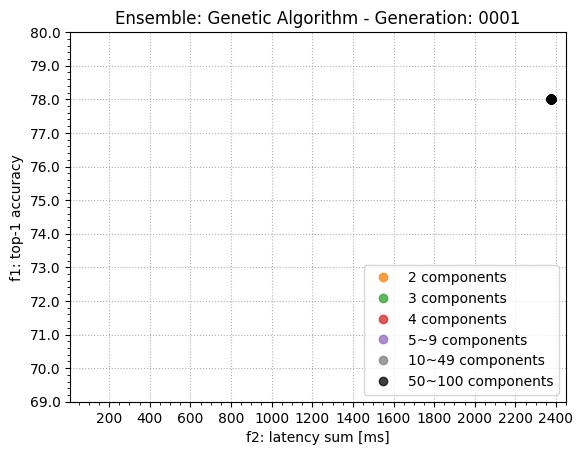

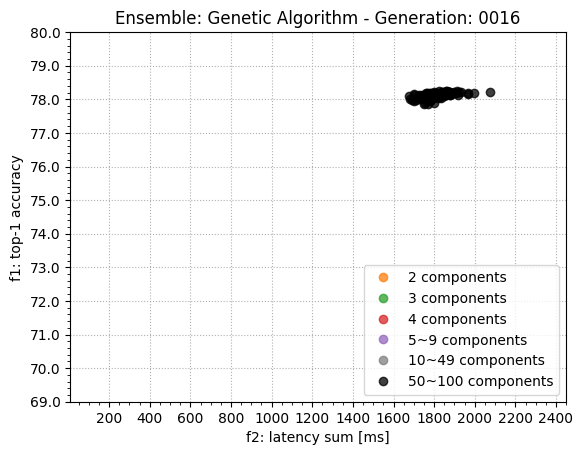

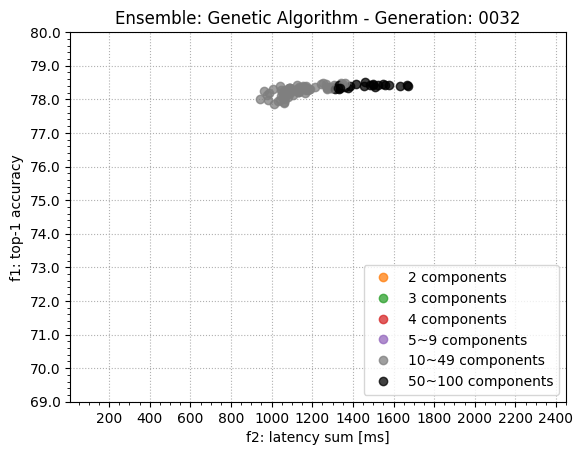

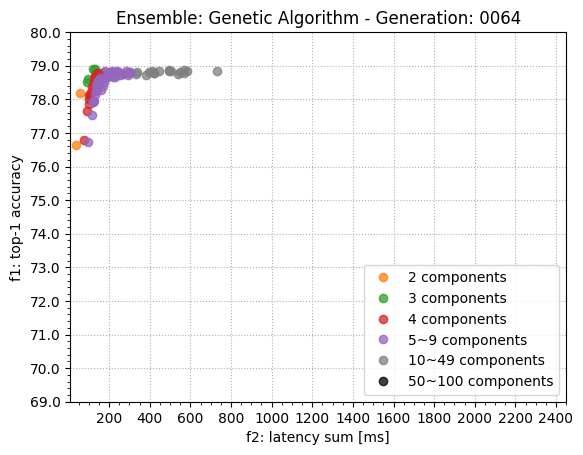

In [61]:
x_min, x_max, y_min, y_max = 8, 2450, 69, 80
ticks = [200, 50, 1, 0.2]
#limit = [0, 60]
#for i in tqdm(range(limit[0], limit[1]+1)):
for i in [0, 15, 31, 63]:
    filename = str(i).zfill(len(str(N))) + '.png'
    # calculate ensemble accuracy
    ofa3_sum_accuracy_progression = [calc_ensemble_accuracy(X[i][j], cumulative_lut, labels, device=cuda0) for j in tqdm(range(len(X[i])))]
    plot_ensemble_performance_latsum(
        lat[i],
        ofa3_sum_accuracy_progression,
        X[i],
        title='Ensemble: Genetic Algorithm - Generation: ' + str(i+1).zfill(len(str(N))),
        ax_limits=[x_min, x_max, y_min, y_max],
        ticks=ticks,
        filename=os.path.join('figures', 'ofa3_pop_progression', 'NSGA-II', 'soft-latsum', 'seed_1', filename),
        #filename=None,
        #show=False,
        show=True,
        ensemble=True,
    )

Generations #0, #15, #31, #63

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

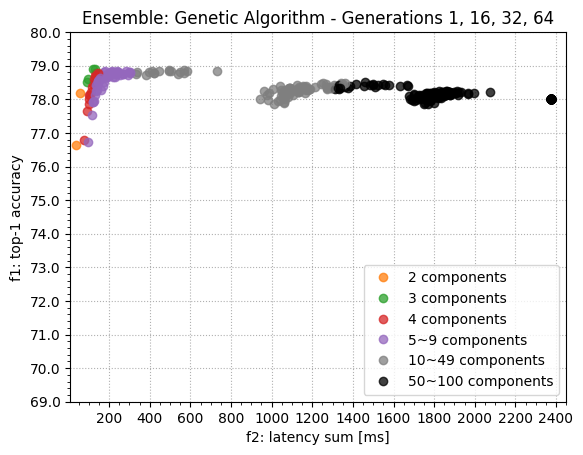

In [62]:
fig, ax = plt.subplots(dpi=600)
x_min, x_max, y_min, y_max = 8, 2450, 69, 80
ticks = [200, 50, 1, 0.2]
generations = [0, 15, 31, 63]
#-------------------------------------------------
# ax.plot(res_moo_lat, top1_moo, 'o', color=blue, alpha=0.75, label='MOO: single architectures')
#-------------------------------------------------
for gen in generations:
    # calculate ensemble accuracy
    components = np.count_nonzero(X[gen], axis=1)
    ofa3_sum_accuracy_progression = [calc_ensemble_accuracy(X[gen][j], cumulative_lut, labels, device=cuda0) for j in tqdm(range(len(X[gen])))]
    for i in range(len(lat[gen])):
        if components[i] >= 50:
            ax.plot(lat[gen][i], ofa3_sum_accuracy_progression[i], 'o', color=black, alpha=0.75, label='50~100 components')
        elif ( (components[i] >= 10) and (components[i] <= 49) ):
            ax.plot(lat[gen][i], ofa3_sum_accuracy_progression[i], 'o', color=gray, alpha=0.75, label='10~49 components')
        elif ( (components[i] >= 5) and (components[i] <= 9) ):
            ax.plot(lat[gen][i], ofa3_sum_accuracy_progression[i], 'o', color=purple, alpha=0.75, label='5~9 components')
        elif components[i] == 4:
            ax.plot(lat[gen][i], ofa3_sum_accuracy_progression[i], 'o', color=red, alpha=0.75, label='4 components')
        elif components[i] == 3:
            ax.plot(lat[gen][i], ofa3_sum_accuracy_progression[i], 'o', color=green, alpha=0.75, label='3 components')
        elif components[i] == 2:
            ax.plot(lat[gen][i], ofa3_sum_accuracy_progression[i], 'o', color=orange, alpha=0.75, label='2 components')
        # if components[i] == 2:
        #     ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=orange, alpha=0.75, label='MOO Ensemble: 2 components')
        # elif components[i] == 3:
        #     ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=green, alpha=0.75, label='MOO Ensemble: 3 components')
        # elif components[i] == 4:
        #     ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=red, alpha=0.75, label='MOO Ensemble: 4 components')
#-------------------------------------------------
leg_blue   = mlines.Line2D([], [], color=blue,   alpha=0.75, marker='o', linestyle='None', label='single architectures')
leg_orange = mlines.Line2D([], [], color=orange, alpha=0.75, marker='o', linestyle='None', label='2 components')
leg_green  = mlines.Line2D([], [], color=green,  alpha=0.75, marker='o', linestyle='None', label='3 components')
leg_red    = mlines.Line2D([], [], color=red,    alpha=0.75, marker='o', linestyle='None', label='4 components')
leg_purple = mlines.Line2D([], [], color=purple, alpha=0.75, marker='o', linestyle='None', label='5~9 components')
leg_gray   = mlines.Line2D([], [], color=gray,   alpha=0.75, marker='o', linestyle='None', label='10~49 components')
leg_black  = mlines.Line2D([], [], color=black,  alpha=0.75, marker='o', linestyle='None', label='50~100 components')
ax.legend(handles=[leg_orange, leg_green, leg_red, leg_purple, leg_gray, leg_black], loc='lower right')
#-------------------------------------------------
ax.grid(True, linestyle=':')
ax.xaxis.set_major_locator(MultipleLocator(ticks[0]))
ax.xaxis.set_minor_locator(MultipleLocator(ticks[1]))
ax.yaxis.set_major_locator(MultipleLocator(ticks[2]))
ax.yaxis.set_minor_locator(MultipleLocator(ticks[3]))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_xlabel('f2: latency sum [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title(f'Ensemble: Genetic Algorithm - Generations {generations[0]+1}, {generations[1]+1}, {generations[2]+1}, {generations[3]+1}'),
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
filename=os.path.join('figures', 'ofa3_pop_progression', 'NSGA-II', 'soft-latsum', 'seed_1', f'gen_{generations[0]}_{generations[1]}_{generations[2]}_{generations[3]}.png')
plt.savefig(filename)
fig.set_dpi(100)
#plt.close(fig)

Population from 70

  0%|          | 0/100 [00:00<?, ?it/s]

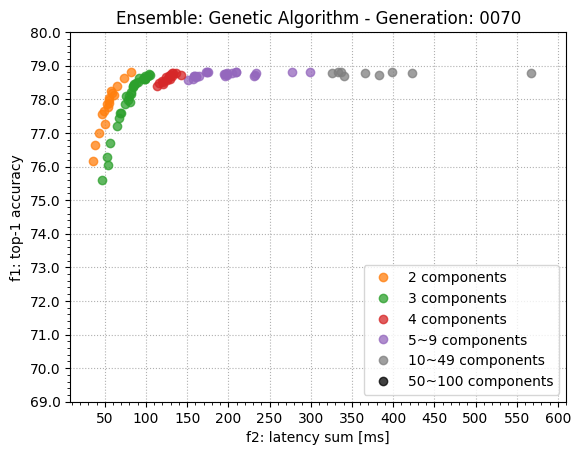

In [63]:
x_min, x_max, y_min, y_max = 8, 610, 69, 80
ticks = [50, 10, 1, 0.2]
#limit = [0, 60]
#for i in tqdm(range(limit[0], limit[1]+1)):
for i in [69]:
    filename = str(i).zfill(len(str(N))) + '.png'
    # calculate ensemble accuracy
    ofa3_sum_accuracy_progression = [calc_ensemble_accuracy(X[i][j], cumulative_lut, labels, device=cuda0) for j in tqdm(range(len(X[i])))]
    plot_ensemble_performance_latsum(
        lat[i],
        ofa3_sum_accuracy_progression,
        X[i],
        title='Ensemble: Genetic Algorithm - Generation: ' + str(i+1).zfill(len(str(N))),
        ax_limits=[x_min, x_max, y_min, y_max],
        ticks=ticks,
        filename=os.path.join('figures', 'ofa3_pop_progression', 'NSGA-II', 'soft-latsum', 'seed_1', filename),
        #filename=None,
        #show=False,
        show=True,
        ensemble=True,
    )

Population 1,000

  0%|          | 0/100 [00:00<?, ?it/s]

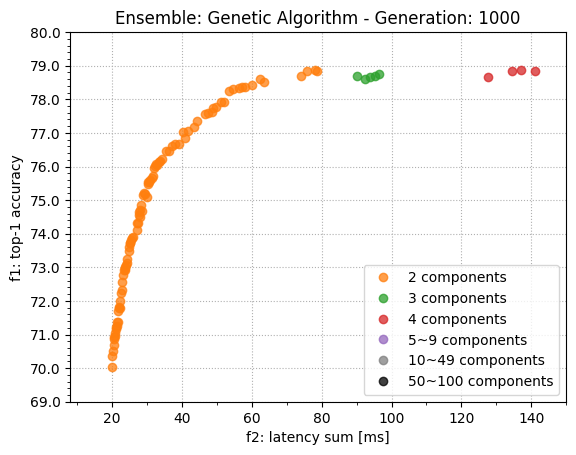

In [64]:
x_min, x_max, y_min, y_max = 8, 150, 69, 80
ticks = [20, 10, 1, 0.2]
#limit = [0, 60]
#for i in tqdm(range(limit[0], limit[1]+1)):
for i in [999]:
    filename = str(i).zfill(len(str(N))) + '.png'
    # calculate ensemble accuracy
    ofa3_sum_accuracy_progression = [calc_ensemble_accuracy(X[i][j], cumulative_lut, labels, device=cuda0) for j in tqdm(range(len(X[i])))]
    plot_ensemble_performance_latsum(
        lat[i],
        ofa3_sum_accuracy_progression,
        X[i],
        title='Ensemble: Genetic Algorithm - Generation: ' + str(i+1).zfill(len(str(N))),
        ax_limits=[x_min, x_max, y_min, y_max],
        ticks=ticks,
        filename=os.path.join('figures', 'ofa3_pop_progression', 'NSGA-II', 'soft-latsum', 'seed_1', filename),
        #filename=None,
        #show=False,
        show=True,
        ensemble=True,
    )

Comparison with single architectures

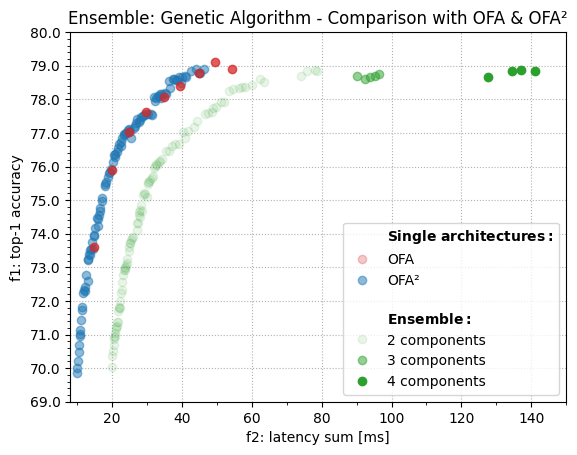

In [65]:
fig, ax = plt.subplots(dpi=600)
x_min, x_max, y_min, y_max = 8, 150, 69, 80
ticks = [20, 10, 1, 0.2]
#-------------------------------------------------
ax.plot(ofa2_nsga2_latency, ofa2_nsga2_accuracy_eval, 'o', label='OFA²', color=blue,  alpha=0.50)
ax.plot(ofa_latency, ofa_accuracy_eval,               'o', label='OFA',                  color=red,   alpha=0.75)
#-------------------------------------------------
# calculate ensemble accuracy
components = np.count_nonzero(X[-1], axis=1)
#ofa3_sum_accuracy_progression = [calc_ensemble_accuracy(X[-1][j], cumulative_lut, labels, device=cuda0) for j in tqdm(range(len(X[-1])))]
for i in range(len(lat[-1])):
    if components[i] >= 50:
        ax.plot(lat[-1][i], ofa3_sum_accuracy_progression[i], 'o', color=green, alpha=1.00, label='50~100 components')
    elif ( (components[i] >= 10) and (components[i] <= 49) ):
        ax.plot(lat[-1][i], ofa3_sum_accuracy_progression[i], 'o', color=green, alpha=1.00, label='10~49 components')
    elif ( (components[i] >= 5) and (components[i] <= 9) ):
        ax.plot(lat[-1][i], ofa3_sum_accuracy_progression[i], 'o', color=green, alpha=1.00, label='5~9 components')
    elif components[i] == 4:
        ax.plot(lat[-1][i], ofa3_sum_accuracy_progression[i], 'o', color=green, alpha=1.00, label='4 components')
    elif components[i] == 3:
        ax.plot(lat[-1][i], ofa3_sum_accuracy_progression[i], 'o', color=green, alpha=0.50, label='3 components')
    elif components[i] == 2:
        ax.plot(lat[-1][i], ofa3_sum_accuracy_progression[i], 'o', color=green, alpha=0.10, label='2 components')
#-------------------------------------------------
leg_single  = mlines.Line2D([], [], color='None', label='$\\bf{Single\ architectures:}$')
leg_red     = mlines.Line2D([], [], color=red,   alpha=0.25, marker='o', linestyle='None', label='OFA')
leg_blue    = mlines.Line2D([], [], color=blue,  alpha=0.50, marker='o', linestyle='None', label='OFA²')
#----------------------------
leg_ens     = mlines.Line2D([], [], color='None', label='\n$\\bf{Ensemble:}$')
leg_green_2 = mlines.Line2D([], [], color=green, alpha=0.10, marker='o', linestyle='None', label='2 components')
leg_green_3 = mlines.Line2D([], [], color=green, alpha=0.50, marker='o', linestyle='None', label='3 components')
leg_green_4 = mlines.Line2D([], [], color=green, alpha=1.00, marker='o', linestyle='None', label='4 components')
#leg_purple = mlines.Line2D([], [], color=green,  alpha=0.75, marker='o', linestyle='None', label='5~9 components')
#leg_gray   = mlines.Line2D([], [], color=green,  alpha=0.75, marker='o', linestyle='None', label='10~49 components')
#leg_black  = mlines.Line2D([], [], color=green,  alpha=0.75, marker='o', linestyle='None', label='50~100 components')
#ax.legend(handles=[leg_orange, leg_green, leg_green, leg_purple, leg_gray, leg_black], loc='lower right')
ax.legend(handles=[leg_single, leg_red, leg_blue, leg_ens, leg_green_2, leg_green_3, leg_green_4], loc='lower right')
#-------------------------------------------------
ax.grid(True, linestyle=':')
ax.xaxis.set_major_locator(MultipleLocator(ticks[0]))
ax.xaxis.set_minor_locator(MultipleLocator(ticks[1]))
ax.yaxis.set_major_locator(MultipleLocator(ticks[2]))
ax.yaxis.set_minor_locator(MultipleLocator(ticks[3]))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_xlabel('f2: latency sum [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title(f'Ensemble: Genetic Algorithm - Comparison with OFA & OFA²'),
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
filename = os.path.join('figures', 'ofa3_pop_progression', 'NSGA-II', 'soft-latsum', 'seed_1', 'ofa2_ofa3_comparison.png')
plt.savefig(filename)
fig.set_dpi(100)
#plt.close(fig)

### SMS-EMOA

In [66]:
# TBD

### SPEA2

In [67]:
# TBD

## Maximum Latency

In [68]:
def plot_ensemble_performance_latmax(latency, accuracy, X, title='Population', ensemble=False, ax_limits=None, filename=None, show=True, color='#1f77b4', ticks=None, hide_leg=False):
    #leg_blue   = mlines.Line2D([], [], color=blue,   marker='o', linestyle='None', label='MOO: single architectures')
    leg_orange = mlines.Line2D([], [], color=orange, alpha=0.75, marker='o', linestyle='None', label='2 components')
    leg_green  = mlines.Line2D([], [], color=green,  alpha=0.75, marker='o', linestyle='None', label='3 components')
    leg_red    = mlines.Line2D([], [], color=red,    alpha=0.75, marker='o', linestyle='None', label='4 components')
    leg_purple = mlines.Line2D([], [], color=purple, alpha=0.75, marker='o', linestyle='None', label='5~9 components')
    leg_gray   = mlines.Line2D([], [], color=gray,   alpha=0.75, marker='o', linestyle='None', label='10~49 components')
    leg_black  = mlines.Line2D([], [], color=black,  alpha=0.75, marker='o', linestyle='None', label='50~100 components')
    #if (filename is not None):
    #    fig, ax = plt.subplots(dpi=600)
    #else:
    #    fig, ax = plt.subplots(dpi=100)
    fig, ax = plt.subplots()
    if ensemble:
        components = np.count_nonzero(X, axis=1)
        for i, c in enumerate(components):
            if c == 2:
                ax.plot(latency[i], accuracy[i], 'o', color=orange, alpha=0.75, label='2 components')
            elif c == 3:
                ax.plot(latency[i], accuracy[i], 'o', color=green, alpha=0.75, label='3 components')
            elif c == 4:
                ax.plot(latency[i], accuracy[i], 'o', color=red, alpha=0.75, label='4 components')
            elif ( (c >= 5) and (c <= 9) ):
                ax.plot(latency[i], accuracy[i], 'o', color=purple, alpha=0.75, label='5~9 components')
            elif ( (c >= 10) and (c <= 49) ):
                ax.plot(latency[i], accuracy[i], 'o', color=gray, alpha=0.75, label='10~49 components')
            elif c >= 50:
                ax.plot(latency[i], accuracy[i], 'o', color=black, alpha=0.75, label='50~100 components')
        # ax.legend(handles=[blue, orange, green, red, gray, black], loc='lower right')
        if hide_leg:
            ax.legend(handles=[leg_red, leg_purple, leg_gray, leg_black], loc='lower right')
        else:
            ax.legend(handles=[leg_orange, leg_green, leg_red, leg_purple, leg_gray, leg_black], loc='lower right')
        # ax.legend()
        ax.grid(True, linestyle=':')
        ax.set_xlabel('f2: latency max [ms]')
        ax.set_ylabel('f1: top-1 accuracy')
        # fig.suptitle(title)
        ax.set_title(title),
        if ticks is not None:
            # x-axis ticks
            ax.xaxis.set_major_locator(MultipleLocator(ticks[0]))
            ax.xaxis.set_minor_locator(MultipleLocator(ticks[1]))
            # y-axis ticks
            ax.yaxis.set_major_locator(MultipleLocator(ticks[2]))
            ax.yaxis.set_minor_locator(MultipleLocator(ticks[3]))
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        if ax_limits is not None:
            ax.set(xlim=(ax_limits[0], ax_limits[1]), ylim=(ax_limits[2], ax_limits[3]))
        if (filename is not None):
            plt.savefig(filename, dpi=600)
        if not show:
            plt.close(fig)

### NSGA-II

In [69]:
P = 100
N = 2_000
history = []
#----------------------------
debug = True
# debug = False
if debug:
    for generation in range(1, N+1):
        filename = 'gen_' + str(generation).zfill(4) + '.pickle'
        with open(os.path.join('ofa3_ensemble', 'NSGA-II', 'soft-latmax-generation', 'seed_1', filename), 'br') as f:
            _, X, F, G = pickle.load(f)
        history.append((X, F, G))

In [70]:
X = []
lat = []
acc = []
size = []
#----------------------------
for hist in history:
    X.append(hist[0])
    lat.append(hist[1][:,0])
    acc.append(hist[1][:,1])
    size.append(2 - hist[2])
#----------------------------
# fix first generation
X[0] = np.repeat(X[0], P, axis=0)
lat[0] = np.repeat(lat[0], P, axis=0)
acc[0] = np.repeat(acc[0], P, axis=0)
size[0] = np.repeat(size[0], P, axis=0)

Populations 0, 63, 511

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

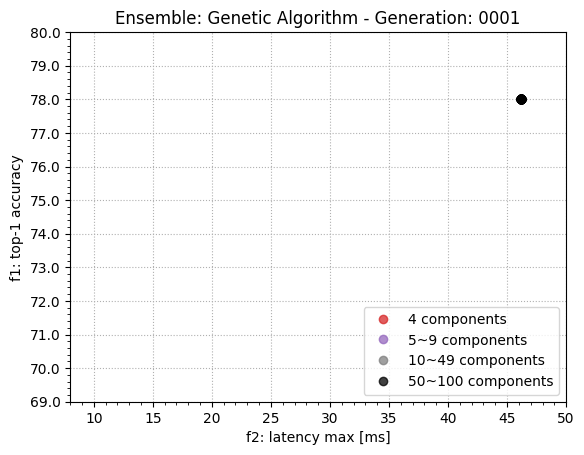

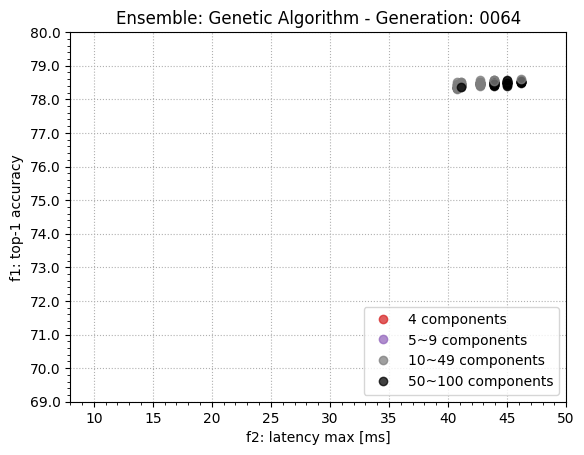

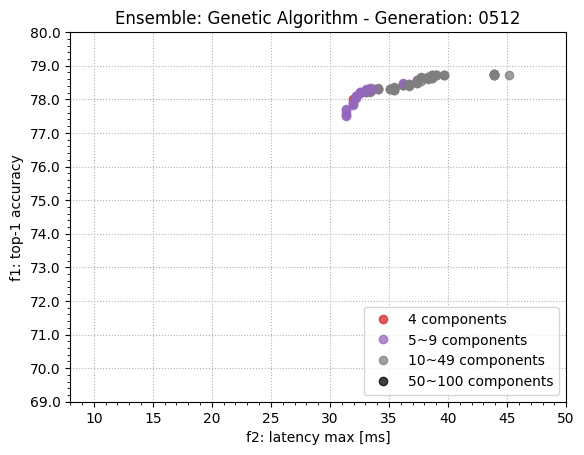

In [71]:
x_min, x_max, y_min, y_max = 8, 50, 69, 80
ticks = [5, 1, 1, 0.2]
#limit = [0, 60]
#for i in tqdm(range(limit[0], limit[1]+1)):
for i in [0, 63, 511]:
    filename = str(i).zfill(len(str(N))) + '.png'
    # calculate ensemble accuracy
    ofa3_max_accuracy_progression = [calc_ensemble_accuracy(X[i][j], cumulative_lut, labels, device=cuda0) for j in tqdm(range(len(X[i])))]
    plot_ensemble_performance_latmax(
        lat[i],
        ofa3_max_accuracy_progression,
        X[i],
        title='Ensemble: Genetic Algorithm - Generation: ' + str(i+1).zfill(len(str(N))),
        ax_limits=[x_min, x_max, y_min, y_max],
        ticks=ticks,
        filename=os.path.join('figures', 'ofa3_pop_progression', 'NSGA-II', 'soft-latmax', 'seed_1', filename),
        #filename=None,
        #show=False,
        hide_leg=True,
        show=True,
        ensemble=True,
    )

Generations #0, #63, #511

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

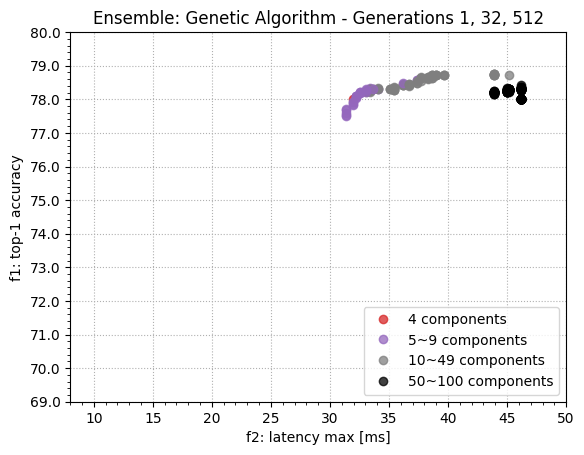

In [72]:
fig, ax = plt.subplots(dpi=600)
x_min, x_max, y_min, y_max = 8, 50, 69, 80
ticks = [5, 1, 1, 0.2]
generations = [0, 31, 511]
#-------------------------------------------------
# ax.plot(res_moo_lat, top1_moo, 'o', color=blue, alpha=0.75, label='MOO: single architectures')
#-------------------------------------------------
for gen in generations:
    # calculate ensemble accuracy
    components = np.count_nonzero(X[gen], axis=1)
    ofa3_max_accuracy_progression = [calc_ensemble_accuracy(X[gen][j], cumulative_lut, labels, device=cuda0) for j in tqdm(range(len(X[gen])))]
    for i in range(len(lat[gen])):
        if components[i] >= 50:
            ax.plot(lat[gen][i], ofa3_max_accuracy_progression[i], 'o', color=black, alpha=0.75, label='50~100 components')
        elif ( (components[i] >= 10) and (components[i] <= 49) ):
            ax.plot(lat[gen][i], ofa3_max_accuracy_progression[i], 'o', color=gray, alpha=0.75, label='10~49 components')
        elif ( (components[i] >= 5) and (components[i] <= 9) ):
            ax.plot(lat[gen][i], ofa3_max_accuracy_progression[i], 'o', color=purple, alpha=0.75, label='5~9 components')
        elif components[i] == 4:
            ax.plot(lat[gen][i], ofa3_max_accuracy_progression[i], 'o', color=red, alpha=0.75, label='4 components')
        elif components[i] == 3:
            ax.plot(lat[gen][i], ofa3_max_accuracy_progression[i], 'o', color=green, alpha=0.75, label='3 components')
        elif components[i] == 2:
            ax.plot(lat[gen][i], ofa3_max_accuracy_progression[i], 'o', color=orange, alpha=0.75, label='2 components')
        # if components[i] == 2:
        #     ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=orange, alpha=0.75, label='MOO Ensemble: 2 components')
        # elif components[i] == 3:
        #     ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=green, alpha=0.75, label='MOO Ensemble: 3 components')
        # elif components[i] == 4:
        #     ax.plot(lat[gen][i], 100 - acc[gen][i], 'o', color=red, alpha=0.75, label='MOO Ensemble: 4 components')
#-------------------------------------------------
leg_blue   = mlines.Line2D([], [], color=blue,   alpha=0.75, marker='o', linestyle='None', label='single architectures')
leg_orange = mlines.Line2D([], [], color=orange, alpha=0.75, marker='o', linestyle='None', label='2 components')
leg_green  = mlines.Line2D([], [], color=green,  alpha=0.75, marker='o', linestyle='None', label='3 components')
leg_red    = mlines.Line2D([], [], color=red,    alpha=0.75, marker='o', linestyle='None', label='4 components')
leg_purple = mlines.Line2D([], [], color=purple, alpha=0.75, marker='o', linestyle='None', label='5~9 components')
leg_gray   = mlines.Line2D([], [], color=gray,   alpha=0.75, marker='o', linestyle='None', label='10~49 components')
leg_black  = mlines.Line2D([], [], color=black,  alpha=0.75, marker='o', linestyle='None', label='50~100 components')
#ax.legend(handles=[leg_orange, leg_green, leg_red, leg_purple, leg_gray, leg_black], loc='lower right')
ax.legend(handles=[leg_red, leg_purple, leg_gray, leg_black], loc='lower right')
#-------------------------------------------------
ax.grid(True, linestyle=':')
ax.xaxis.set_major_locator(MultipleLocator(ticks[0]))
ax.xaxis.set_minor_locator(MultipleLocator(ticks[1]))
ax.yaxis.set_major_locator(MultipleLocator(ticks[2]))
ax.yaxis.set_minor_locator(MultipleLocator(ticks[3]))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_xlabel('f2: latency max [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title(f'Ensemble: Genetic Algorithm - Generations {generations[0]+1}, {generations[1]+1}, {generations[2]+1}')
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
filename = os.path.join('figures', 'ofa3_pop_progression', 'NSGA-II', 'soft-latmax', 'seed_1', f'gen_{generations[0]}_{generations[1]}_{generations[2]}.png')
plt.savefig(filename)
fig.set_dpi(100)
#plt.close(fig)

Population 1,024

  0%|          | 0/100 [00:00<?, ?it/s]

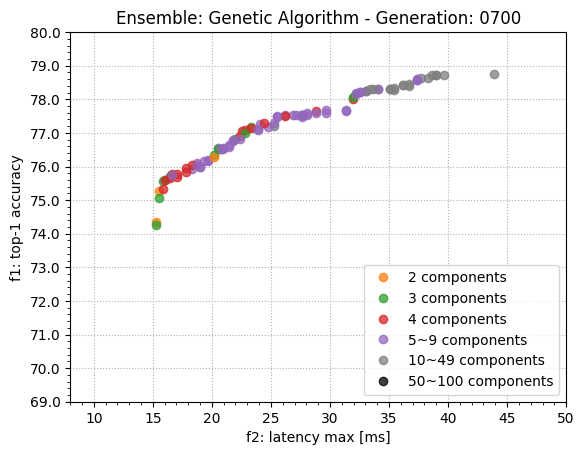

In [73]:
x_min, x_max, y_min, y_max = 8, 50, 69, 80
ticks = [5, 1, 1, 0.2]
#limit = [0, 60]
#for i in tqdm(range(limit[0], limit[1]+1)):
for i in [699]:
    filename = str(i).zfill(len(str(N))) + '.png'
    # calculate ensemble accuracy
    ofa3_max_accuracy_progression = [calc_ensemble_accuracy(X[i][j], cumulative_lut, labels, device=cuda0) for j in tqdm(range(len(X[i])))]
    plot_ensemble_performance_latmax(
        lat[i],
        ofa3_max_accuracy_progression,
        X[i],
        title='Ensemble: Genetic Algorithm - Generation: ' + str(i+1).zfill(len(str(N))),
        ax_limits=[x_min, x_max, y_min, y_max],
        ticks=ticks,
        filename=os.path.join('figures', 'ofa3_pop_progression', 'NSGA-II', 'soft-latmax', 'seed_1', filename),
        #filename=None,
        #show=False,
        show=True,
        ensemble=True,
    )

Population 2,000

  0%|          | 0/100 [00:00<?, ?it/s]

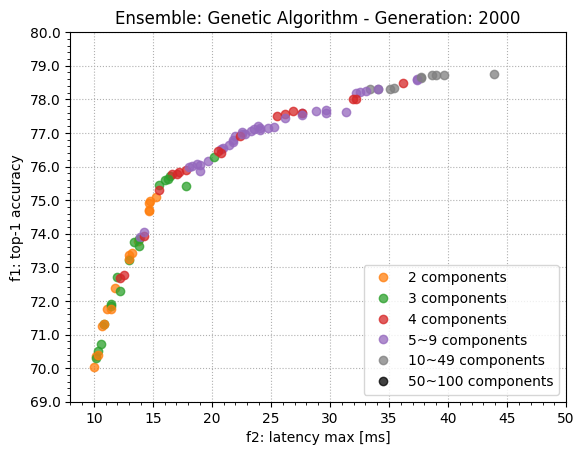

In [74]:
x_min, x_max, y_min, y_max = 8, 50, 69, 80
ticks = [5, 1, 1, 0.2]
#limit = [0, 60]
#for i in tqdm(range(limit[0], limit[1]+1)):
for i in [1999]:
    filename = str(i).zfill(len(str(N))) + '.png'
    # calculate ensemble accuracy
    ofa3_max_accuracy_progression = [calc_ensemble_accuracy(X[i][j], cumulative_lut, labels, device=cuda0) for j in tqdm(range(len(X[i])))]
    plot_ensemble_performance_latmax(
        lat[i],
        ofa3_max_accuracy_progression,
        X[i],
        title='Ensemble: Genetic Algorithm - Generation: ' + str(i+1).zfill(len(str(N))),
        ax_limits=[x_min, x_max, y_min, y_max],
        ticks=ticks,
        filename=os.path.join('figures', 'ofa3_pop_progression', 'NSGA-II', 'soft-latmax', 'seed_1', filename),
        #filename=None,
        #show=False,
        show=True,
        ensemble=True,
    )

Comparison with single architectures

  0%|          | 0/100 [00:00<?, ?it/s]

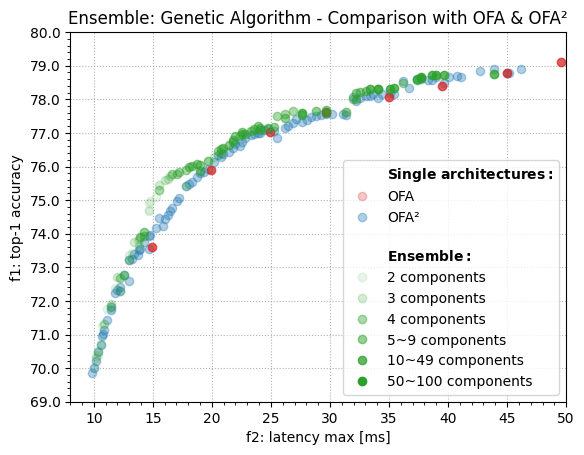

In [75]:
fig, ax = plt.subplots(dpi=600)
x_min, x_max, y_min, y_max = 8, 50, 69, 80
ticks = [5, 1, 1, 0.2]
#-------------------------------------------------
ax.plot(ofa2_nsga2_latency, ofa2_nsga2_accuracy_eval, 'o', label='Single architectures', color=blue,  alpha=0.35)
ax.plot(ofa_latency, ofa_accuracy_eval,               'o', label='OFA',                  color=red,   alpha=0.75)
#-------------------------------------------------
scale = [0.10, 0.20, 0.40, 0.50, 0.75, 1.00]
# calculate ensemble accuracy
components = np.count_nonzero(X[-1], axis=1)
ofa3_max_accuracy_progression = [calc_ensemble_accuracy(X[-1][j], cumulative_lut, labels, device=cuda0) for j in tqdm(range(len(X[-1])))]
for i in range(len(lat[-1])):
    if components[i] >= 50:
        ax.plot(lat[-1][i], ofa3_max_accuracy_progression[i], 'o', color=green, alpha=scale[5], label='50~100 components')
    elif ( (components[i] >= 10) and (components[i] <= 49) ):
        ax.plot(lat[-1][i], ofa3_max_accuracy_progression[i], 'o', color=green, alpha=scale[4], label='10~49 components')
    elif ( (components[i] >= 5) and (components[i] <= 9) ):
        ax.plot(lat[-1][i], ofa3_max_accuracy_progression[i], 'o', color=green, alpha=scale[3], label='5~9 components')
    elif components[i] == 4:
        ax.plot(lat[-1][i], ofa3_max_accuracy_progression[i], 'o', color=green, alpha=scale[2], label='4 components')
    elif components[i] == 3:
        ax.plot(lat[-1][i], ofa3_max_accuracy_progression[i], 'o', color=green, alpha=scale[1], label='3 components')
    elif components[i] == 2:
        ax.plot(lat[-1][i], ofa3_max_accuracy_progression[i], 'o', color=green, alpha=scale[0], label='2 components')
#-------------------------------------------------
leg_single  = mlines.Line2D([], [], color='None', label='$\\bf{Single\ architectures:}$')
leg_red      = mlines.Line2D([], [], color=red,   alpha=0.25, marker='o', linestyle='None', label='OFA')
leg_blue     = mlines.Line2D([], [], color=blue,  alpha=0.35, marker='o', linestyle='None', label='OFA²')
#----------------------------
leg_ens     = mlines.Line2D([], [], color='None', label='\n$\\bf{Ensemble:}$')
leg_green_2  = mlines.Line2D([], [], color=green, alpha=scale[0], marker='o', linestyle='None', label='2 components')
leg_green_3  = mlines.Line2D([], [], color=green, alpha=scale[1], marker='o', linestyle='None', label='3 components')
leg_green_4  = mlines.Line2D([], [], color=green, alpha=scale[2], marker='o', linestyle='None', label='4 components')
leg_green_5  = mlines.Line2D([], [], color=green, alpha=scale[3], marker='o', linestyle='None', label='5~9 components')
leg_green_10 = mlines.Line2D([], [], color=green, alpha=scale[4], marker='o', linestyle='None', label='10~49 components')
leg_green_50 = mlines.Line2D([], [], color=green, alpha=scale[5], marker='o', linestyle='None', label='50~100 components')
#ax.legend(handles=[leg_orange, leg_green, leg_green, leg_purple, leg_gray, leg_black], loc='lower right')
ax.legend(handles=[leg_single, leg_red, leg_blue, leg_ens, leg_green_2, leg_green_3, leg_green_4, leg_green_5, leg_green_10, leg_green_50], loc='lower right')
#-------------------------------------------------
ax.grid(True, linestyle=':')
ax.xaxis.set_major_locator(MultipleLocator(ticks[0]))
ax.xaxis.set_minor_locator(MultipleLocator(ticks[1]))
ax.yaxis.set_major_locator(MultipleLocator(ticks[2]))
ax.yaxis.set_minor_locator(MultipleLocator(ticks[3]))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_xlabel('f2: latency max [ms]')
ax.set_ylabel('f1: top-1 accuracy')
ax.set_title(f'Ensemble: Genetic Algorithm - Comparison with OFA & OFA²'),
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
filename = os.path.join('figures', 'ofa3_pop_progression', 'NSGA-II', 'soft-latmax', 'seed_1', 'ofa2_ofa3_comparison.png')
plt.savefig(filename)
fig.set_dpi(100)
#plt.close(fig)

### SMS-EMOA

In [76]:
# TBD

### SPEA2

In [77]:
# TBD

# End of Notebook